# Objectif

L’objectif de ce TP est d’analyser un corpus de tweets en fonction des opinions exprimées (positif/-
négatif).

# Import and load data

In [1]:
import pandas as pd
import os
import nltk as nltk
import re
from nltk.corpus import wordnet as wn

In [2]:
df = pd.read_csv('https://clavel.wp.imt.fr/files/2018/05/testdata.manual.2009.06.14.csv_.zip', compression='zip', header=None)

In [3]:
df.columns = ['polarite','id','date','requete','utilisateur','text']

In [4]:
df.head(10)

,polarite,id,date,requete,utilisateur,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
5,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...
6,0,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non lo...
7,4,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,Jquery is my new best friend.
8,4,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,Loves twitter
9,4,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,how can you not love Obama? he makes jokes abo...


In [5]:
d = pd.read_csv('/home/b/gitMSBGD/web_data/Lexiques/SlangLookupTable.txt', sep='\t', encoding='latin1', header=None, index_col=0).to_dict()[1]

# .2 Prétraitements

In [6]:
def algo1(text):
    text = re.sub(r"http\S+", '', text, flags=re.MULTILINE)
    counts = text.count('@'),text.count('#')
    text = text.replace('@','').replace('#','')
    words = nltk.word_tokenize(text)
    return [word if word not in d.keys() else d[word] for word in words], counts

In [7]:
df['nb_@'] = df.text.apply(lambda x: algo1(x)[1][0])
df['nb_#'] = df.text.apply(lambda x: algo1(x)[1][1])

In [8]:
print("Il y a {} @ et {} # dans l'ensemble du corpus".format(df['nb_@'].sum(), df['nb_#'].sum()))

Il y a 128 @ et 52 # dans l'ensemble du corpus


# 3.3 Etiquetage grammatical

In [9]:
def algo2(tokens):
    taggedData = nltk.pos_tag(tokens)
    nb_vb = sum([x[1][:2]=='VB' for x in taggedData])
    return taggedData, nb_vb

In [10]:
df['nb_vb'] = df.text.apply(lambda x : algo2(algo1(x)[0])[1])

In [12]:
print("Il y a {} verbes dans l'ensemble du corpus".format(df['nb_vb'].sum()))

Il y a 1095 verbes dans l'ensemble du corpus


# 3.4 v1 

In [13]:
from nltk.corpus import sentiwordnet as swn

In [14]:
nltk.download('sentiwordnet')

[nltk_data] Downloading package sentiwordnet to /home/b/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

On filtre uniquement les mots correspondant à des adjectifs, noms, adverbes et verbes

In [15]:
def f(taggedData):
    return [x for x in taggedData if x[1][:2] in ['NN','JJ', 'RB','VB']]

In [16]:
def compute_sentiment(pos, neg):
    if pos == neg:
        return 2
    elif pos>neg:
        return 4
    else:
        return 0

In [17]:
def score1(taggedData):
    synsets = [wn.synsets(tag[0]) for tag in taggedData]
    neg = [swn.senti_synset(synset[0].name()).neg_score() if synset!=[] else 0 for synset in synsets]
    pos = [swn.senti_synset(synset[0].name()).pos_score() if synset!=[] else 0 for synset in synsets]
#     print(pos)
    return sum(pos), sum(neg), compute_sentiment(sum(pos), sum(neg))

In [18]:
def v1(x):
    return score1(f(algo2(algo1(x)[0])[0]))[2]

In [19]:
df['score1'] = df.text.apply(v1)

In [30]:
print("Il y a {} tweets postifs correctement détectés".format(np.sum(df[df.polarite==4].score1 == df[df.polarite==4].polarite)))

Il y a 130 tweets postifs correctement détectés


In [38]:
np.mean(df.score1 == df.polarite)

0.5321285140562249

# 3.5 v2 negation et modifieurs

In [23]:
neg_word_list = pd.read_csv('/home/b/gitMSBGD/web_data/Lexiques/NegatingWordList.txt', header=None)[0].values
booster_word_list = pd.read_csv('/home/b/gitMSBGD/web_data/Lexiques/BoosterWordList.txt', header=None)

In [24]:
booster_dict = {x.split('\t')[0]:x.split('\t')[1] for x in booster_word_list[0].values}

In [25]:
neg_in_pos_tweet = 0
def score2(taggedData):
    global neg_in_pos_tweet
    boost_idx = [idx+1 for idx, tag in enumerate(taggedData) if tag[0] in booster_dict.keys()]
    neg_idx = [idx+1 for idx, tag in enumerate(taggedData) if tag[0] in neg_word_list]
    synsets = [wn.synsets(tag[0]) for tag in taggedData]
    neg = [swn.senti_synset(synset[0].name()).neg_score() if synset!=[] else 0 for synset in synsets]
    pos = [swn.senti_synset(synset[0].name()).pos_score() if synset!=[] else 0 for synset in synsets]
    neg = [neg[i]*2 if i in boost_idx else neg[i] for i in range(len(neg))]
    pos = [pos[i]*2 if i in boost_idx else pos[i] for i in range(len(pos))]
    neg = [pos[i] if i in neg_idx else neg[i] for i in range(len(neg))]
    pos = [neg[i] if i in neg_idx else pos[i] for i in range(len(pos))]
    sentiment = compute_sentiment(sum(pos), sum(neg))
    if sentiment < 4:
        neg_in_pos_tweet += len(neg_idx)
    return sum(pos), sum(neg), sentiment

In [26]:
def v2(x):
    return score2(f(algo2(algo1(x)[0])[0]))[2]

In [27]:
df['score2'] = df.text.apply(v2)

In [28]:
print("Il y a {} termes négatifs dans les tweets positifs".format(neg_in_pos_tweet))

Il y a 29 termes négatifs dans les tweets positifs


In [32]:
print('Il y a {} tweets positifs correctement détectés, {} neutres et {} négatifs'.format(np.sum(df[df.polarite==4].score2 == df[df.polarite==4].polarite),np.sum(df[df.polarite==2].score2 == df[df.polarite==2].polarite),np.sum(df[df.polarite==0].score2 == df[df.polarite==0].polarite)))

Il y a 131 tweets positifs correctement détectés, 61 neutres et 77 négatifs


In [50]:
np.sum(df.score2 == df.polarite)

269

In [51]:
np.mean(df.score2 == df.polarite)

0.5401606425702812

# 3.6 emoticons

In [33]:
emoticons = pd.read_csv('/home/b/gitMSBGD/web_data/Lexiques/EmoticonLookupTable.txt', sep='\t', header=None, index_col=0).to_dict()[1]


In [34]:
from nltk.tokenize import TweetTokenizer
tokenizer= TweetTokenizer()
def algo1bis(text):
    text = re.sub(r"http\S+", '', text, flags=re.MULTILINE)
    counts = text.count('@'),text.count('#')
    text = text.replace('@','').replace('#','')
    words = tokenizer.tokenize(text)
    return [word if word not in d.keys() else d[word] for word in words], counts

In [35]:
emo_count = 0
def score3(taggedData):
    global emo_count
    emo = [emoticons[tag[0]] for idx, tag in enumerate(taggedData) if tag[0] in emoticons.keys()]
#     print(emo)
    emo_count += len(emo)
    boost_idx = [idx+1 for idx, tag in enumerate(taggedData) if tag[0] in booster_dict.keys()]
    neg_idx = [idx+1 for idx, tag in enumerate(taggedData) if tag[0] in neg_word_list]
    synsets = [wn.synsets(tag[0]) for tag in taggedData]
    neg = [swn.senti_synset(synset[0].name()).neg_score() if synset!=[] else 0 for synset in synsets]
    pos = [swn.senti_synset(synset[0].name()).pos_score() if synset!=[] else 0 for synset in synsets]
#     print(pos)
    neg = [neg[i]*2 if i in boost_idx else neg[i] for i in range(len(neg))]
    pos = [pos[i]*2 if i in boost_idx else pos[i] for i in range(len(pos))]
#     print(pos)
    neg = [pos[i] if i in neg_idx else neg[i] for i in range(len(neg))]
    pos = [neg[i] if i in neg_idx else pos[i] for i in range(len(pos))]
    pos, neg = sum(pos)+sum([x>0 for x in emo]), sum(neg)+sum([x<0 for x in emo])
    return pos, neg, compute_sentiment(pos, neg)

In [37]:
def v3(x):
    return score3(f(algo2(algo1bis(x)[0])[0]))[2]

In [38]:
df['score3'] = df.text.apply(v3)

In [40]:
print('Il y a {} emoticons présents dans le corpus'.format(emo_count))

Il y a 56 emoticons présents dans le corpus


In [41]:
print('Il y a {} tweets positifs correctement détectés, {} neutres et {} négatifs'.format(np.sum(df[df.polarite==4].score3 == df[df.polarite==4].polarite),np.sum(df[df.polarite==2].score3 == df[df.polarite==2].polarite),np.sum(df[df.polarite==0].score3 == df[df.polarite==0].polarite)))

Il y a 138 tweets positifs correctement détectés, 62 neutres et 84 négatifs


In [59]:
np.sum(df.score3 == df.polarite)

284

In [60]:
np.mean(df.score3 == df.polarite)

0.570281124497992

In [42]:
from sklearn.metrics import confusion_matrix

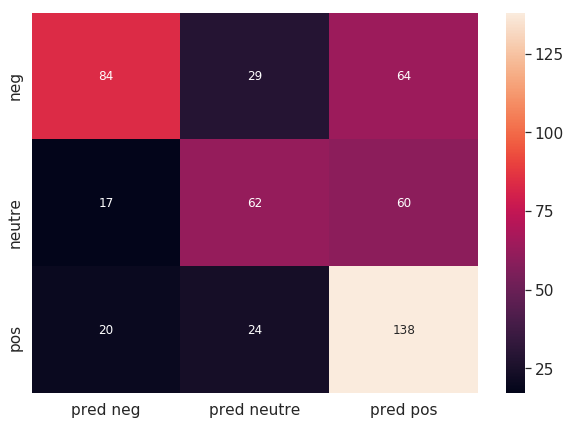

In [44]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
labels=['neg','neutre','pos']
cm = confusion_matrix(df.polarite, df.score3)
df_cm = pd.DataFrame(cm, labels,
                  ['pred '+x for x in labels])
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='.0f')# font size

# V4

J'ai d'abord commencé par traiter le cas des lettres répétées: je me suis rendu qu'un mot comme loooooovvvve n'etait pas reconnu par nltk. J'ai donc décidé de remplacer toutes répétitions de 3 lettres ou plus par une seule.

In [45]:
def delete_cons_car(text):
    found = re.findall(r'((\w)\2{2,})', text)
#     print(found)
    for x in found:
        text = text.replace(x[0],x[1])
    return text

In [46]:
def algo1ter(text):
    text = re.sub(r"http\S+", '', text, flags=re.MULTILINE)
    counts = text.count('@'),text.count('#')
    text = text.replace('@','').replace('#','')
    text = delete_cons_car(text)
    words = tokenizer.tokenize(text)
    return [word if word not in d.keys() else d[word] for word in words], counts

In [47]:
def v4(text):
    return score3(f(algo2(algo1ter(text)[0])[0]))[2]

In [48]:
df['score4'] = df.text.apply(v4)

In [49]:
np.mean(df.score4 == df.polarite)

0.5742971887550201

In [50]:
np.sum(df.score4 == df.polarite)

286

Cela me permet de correctement détecté 2 tweets supplémentaires. J'ai essayé d'autres choses comme gardé uniquement le score de l'emoticon s'il y en a une dans le tweet, de comparer le nombre de mots avec un score négatifs avec le nombre de mots ayant un score positif mais cela n'a pas permis d'améliorer, tout comme l'ajout du stemming. J'ai ensuite essyé d'entrainer un modèle après avoir appliqué une TfidfVectorizer:

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
from sklearn.model_selection import train_test_split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df.text.values, df.polarite.values, test_size=0.2)

In [67]:
vectorizer = TfidfVectorizer()
tf_idf_train = vectorizer.fit_transform(X_train)
tf_idf_test = vectorizer.transform(X_test)

In [68]:
tf_train = vectorizer.fit_transform(X_train)
tf_test = vectorizer.transform(X_test)

In [57]:
from sklearn.linear_model import LogisticRegression

In [70]:
model = LogisticRegression()
model.fit(tf_idf_train, y_train)
prediction = model.predict(tf_idf_test)
np.mean(prediction==y_test)

0.7

Ce qui permet d'ameliorer la prediction de plus de 10%.